# Exercise session notes

SVD is a genralization of eigenvalue decomposition.

Given

$$ A = U \cdot D \cdot V^{T} $$

it holds that

$$ \left\{ \begin{array}{l}
    A \cdot V_i = d_i \cdot u_i\\
    A^{T} \cdot U_i = d_i \cdot v_i
\end{array}\right. 
\iff 
\left\{ \begin{array}{l}
    A \cdot A^{T} \cdot U_i = d_{i}^{2} u_{i} \\
    A^{T} \cdot A \cdot V_i = d_{i}^{2} v_{i} 
\end{array}\right. .$$

Exercise: prove that $r(\tilde{A}) = 2$, where $\tilde{A}_2 = U_2 \cdot D_2 \cdot V_2^T$.

# Problem 1 (SVD Theory)

In [28]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import copy
import random

In [29]:
A = np.array([
        [8, 7,      1, np.NaN, 4],
        [9, 7,      2, 5,      6],
        [1, 4,      9, np.NaN, 3],
        [3, np.NaN, 8, 5,      4],
        [np.NaN, 3, np.NaN, 9, 9],
        [5, 1, 4, 10, np.NaN]
    ])

print(A.shape)

(6, 5)


$A \in \mathbb{R}^{M \times N}$.

1. $ K = AA^{T}, K \in \mathbb{R}^{M \times M} $ indicates row-row correlations (movie-movie similarities). Every element (i, j) is just the dot product between movies i and j. Could consider using cosine similarity instead of the dot product in order not to get distracted by the absolute rating when computing similarities (movie pairs with higher ratings lead to larger dot products than equally similar movies but with lower ratings).
2. $ L = A^{T}A, L \in \mathbb{R}^{N \times N}$ indicates column-column correlations (user-user similarities).
3. $ A = UDV^{T}, U: (M \times M), D: (M \times N), V^{T}: (N \times N) $; in our case: $ U: (6 \times 6), D: (6 \times 5), V^{T}: (5 \times 5) $
4. Performing SVD on the rating column would help us isolate some latent concepts. It will, for instance, yield a matrix mapping movies to their belonging to a particular type (or genre), as well as one mapping users to their affinities towards certain genres. Main goal: low-rank approximation of original matrix. Compute missing ratings to use for recommending movies.
5. D contains the singular values $\sigma_{i}$ on its diagonal. It's possible to keep all nonzero singular values, but it's generally more useful to just keep the K largest ones. In our case, we could consider keeping the first three or two.
6. The matrix U can be seen as a description of every movie as a composition of some latent variables.
7. The matrix V can be seen as a description of every user as a composition of some latent variables (e.g. affinities to certain movie genres).

In [30]:
A_imputed = np.nan_to_num(A)
A_imputed[A_imputed == 0] = 5.5
A_imputed

array([[  8. ,   7. ,   1. ,   5.5,   4. ],
       [  9. ,   7. ,   2. ,   5. ,   6. ],
       [  1. ,   4. ,   9. ,   5.5,   3. ],
       [  3. ,   5.5,   8. ,   5. ,   4. ],
       [  5.5,   3. ,   5.5,   9. ,   9. ],
       [  5. ,   1. ,   4. ,  10. ,   5.5]])

In [31]:
def full_svd(matrix):
    """Utility which returns full SVD matrices.
    
    Works around the fact that numpy's SVD function returns the 'd'
    as a vector of singular values, instead of a diagonal matrix.
    """
    U, d, V = np.linalg.svd(matrix, full_matrices=True)
    D = np.zeros(matrix.shape)
    D[:d.shape[0],:d.shape[0]] = np.diag(d)
    return U, D, V

In [32]:
U, D, V = full_svd(A_imputed)

In [33]:
reconstruction = np.dot(U, np.dot(D, V))
reconstruction

array([[ 8. ,  7. ,  1. ,  5.5,  4. ],
       [ 9. ,  7. ,  2. ,  5. ,  6. ],
       [ 1. ,  4. ,  9. ,  5.5,  3. ],
       [ 3. ,  5.5,  8. ,  5. ,  4. ],
       [ 5.5,  3. ,  5.5,  9. ,  9. ],
       [ 5. ,  1. ,  4. , 10. ,  5.5]])

In [34]:
np.allclose(A_imputed, reconstruction)

True

In [35]:
def scatter_label(data, labels):
    """Helper function for pretty scatterplots."""
    plt.scatter(data[:, 0], data[:, 1], s=60)
    for label, x, y in zip(labels, data[:, 0], data[:, 1]):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round, pad=0.5', fc = 'cyan', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

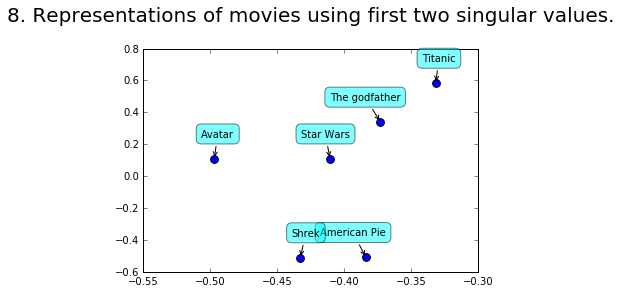

In [36]:
U_2 = U[:,:2]
movie_labels = ['American Pie', 'Shrek', 'Titanic', 'The godfather', 'Avatar', 'Star Wars']
scatter_label(U_2, movie_labels)
    
_ = plt.title("8. Representations of movies using first two singular values.", 
              size=20, y=1.1)

We can interpret the above plot's X axis as a (sort-of) degree of realism, while the Y axis can be seen as a distinction between drama (positive) and comedy (negative).

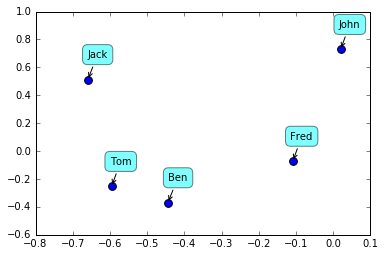

In [37]:
# Idea: analyze massive data and detect cultists who enjoy cult
# classics which some critics consider really bad (e.g. The Room, The Big Lebowski, etc.).

# Idea: analyze stuff user hasn't yet seen. Avoid stuff with very high or very low ratings.

V_2 = V[:,:2]
user_labels = ['Ben', 'Tom', 'John', 'Fred', 'Jack']
scatter_label(V_2, user_labels)

John and Jack prefer more serious movies, while Fred, Tom, and Ben are into comedies. Out of them, Fred seems to be the most well-rounded, but with still quite a strong inclination towards sci-fi.

The second singular value represents the comedy/drama division, while the first one seems to represent the degree of realism.

In [38]:
A_approx = np.dot(U[:,:3], np.dot(D[:3,:], V))
print(A_imputed)
print(A_approx)
error = np.linalg.norm(A_approx - A_imputed)
print("Approximation error (frobenius): %f" % error)

[[  8.    7.    1.    5.5   4. ]
 [  9.    7.    2.    5.    6. ]
 [  1.    4.    9.    5.5   3. ]
 [  3.    5.5   8.    5.    4. ]
 [  5.5   3.    5.5   9.    9. ]
 [  5.    1.    4.   10.    5.5]]
[[ 8.14381143  6.70703714  1.2317371   4.72467418  4.85857698]
 [ 8.8033797   7.26335375  1.79129575  5.52435092  5.50903254]
 [ 0.95925907  3.94727342  9.0413232   5.18969     3.43235702]
 [ 2.97210805  5.54924374  7.96102618  5.12079128  3.87119136]
 [ 5.86276729  2.99598204  5.50525861  9.91415263  7.50719451]
 [ 4.69201023  0.99897876  3.99902904  9.20657586  6.78945711]]
Approximation error (frobenius): 2.841515


## Bob wants to join the system!

In [39]:
Bob = np.array([[1, np.NaN, np.NaN, 6, np.NaN, 10]])
Bob_imputed = np.nan_to_num(Bob)
Bob_imputed[Bob_imputed == 0] = 5.5
Bob_imputed

array([[  1. ,   5.5,   5.5,   6. ,   5.5,  10. ]])

In [40]:
# TODO(andrei) Do this in a prettier way.
A_bob_imputed = np.hstack((A_imputed, Bob_imputed.T))
A_bob_imputed

array([[  8. ,   7. ,   1. ,   5.5,   4. ,   1. ],
       [  9. ,   7. ,   2. ,   5. ,   6. ,   5.5],
       [  1. ,   4. ,   9. ,   5.5,   3. ,   5.5],
       [  3. ,   5.5,   8. ,   5. ,   4. ,   6. ],
       [  5.5,   3. ,   5.5,   9. ,   9. ,   5.5],
       [  5. ,   1. ,   4. ,  10. ,   5.5,  10. ]])

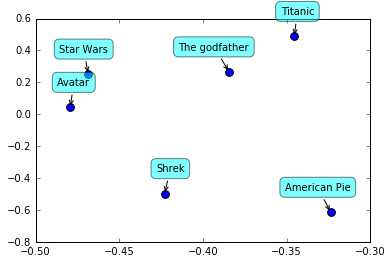

In [41]:
U, D, V = full_svd(A_bob_imputed)
scatter_label(U[:,:2], movie_labels)

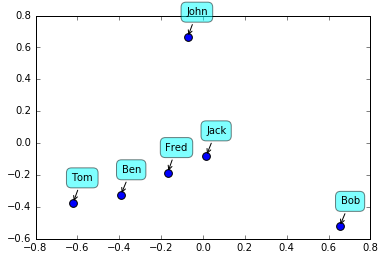

In [42]:
user_labels.append('Bob')
scatter_label(V[:,:2], user_labels)

Bob seems to be close to Fred, in that he also likes more serous movies, but he's even farther than the rest since he absolutely hates comedies such as American Pie.

In [43]:
A_bob_approx = np.dot(U[:,:3], np.dot(D[:3,:], V))
print("Approximate rating matrix including Bob:\n\n", A_bob_approx, "\n")
error_frob = np.linalg.norm(A_approx - A_imputed, ord='fro')
error_euclid = np.linalg.norm(A_approx - A_imputed, ord=2)

print(("Approximation errors after adding Bob to system:\n" +
      "\t- Frobenius norm: %f\n" +
      "\t- Euclidean norm: %f\n") % (error_frob, error_euclid))

Approximate rating matrix including Bob:

 [[ 8.11870044  6.95788447  0.9377407   4.20134564  4.69292636  1.85719128]
 [ 8.69748326  6.84268602  2.2531497   6.35461334  6.08555874  4.00338881]
 [ 0.97046617  3.98861355  8.98026505  5.08553471  3.36424485  5.69892719]
 [ 2.92933045  5.37591483  8.14888354  5.45529057  4.10879584  5.3937604 ]
 [ 6.0251264   3.63659566  4.8863625   8.73931299  6.70438145  7.51978921]
 [ 4.73364366  0.63012137  4.33461873  9.87342924  6.93428591  9.04319165]] 

Approximation errors after adding Bob to system:
	- Frobenius norm: 2.841515
	- Euclidean norm: 2.759945



We use the highest predicted rating which was missing in Bob's original ratings in order to recommend him a movie.

In [44]:
# Get Bob's rating column!
bob_index = user_labels.index('Bob')
Bob_new_ratings = A_bob_approx[:, bob_index]

# Keep track of the original row indices in the column...
Bob_candidates = np.array([np.arange(Bob.shape[1]), Bob_new_ratings])
# ...and only keep rows for movies Bob didn't see yet.
Bob_candidates = Bob_candidates[:, np.isnan(Bob[0])]

# Pick the row with the highest rating.
best_entry = Bob_candidates[:, np.argmax(Bob_candidates[1,:])]
# And then grab the movie index.
best_index = int(best_entry[0])

print("Bob should watch %s!" % movie_labels[best_index])

Bob should watch Avatar!


In closing, Bob's ratings do affect our prediction system, since they add more information (and also a little bit more confusion, due to a slightly larger approximation error) to our data matrix.